In [1]:
# Liberías estandar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

# Funciones de Scikit-Learn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    train_test_split
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Funciones de Yellow Brick
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import (ValidationCurve, FeatureImportances)
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.classifier import (
    ConfusionMatrix,
    ClassPredictionError,
    ClassificationReport,
    PrecisionRecallCurve,
    ROCAUC,
    ClassPredictionError
)

# Importar xgboost
import xgboost as xgb

# Configurar visualizaciones
sns.set_theme(style="whitegrid")
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

SEED = 42

## Cargar los datos

Cargamos los datos. Nuestra variable a predecir es `is_canceled`. (1) es cancelada y (0) no cancelada.

In [5]:
tbl_data = (
    pd.read_csv("../data/raw/hotel_bookings.csv")
)

In [6]:
tbl_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Checar el desbalance en los datos.

In [7]:
(tbl_data
     .groupby(['is_canceled'])
     .size()
     .reset_index(name = 'n_reservaciones')
     .assign(pct = lambda df_: df_.n_reservaciones / df_.n_reservaciones.sum() * 100)
     .round(1)
)

,is_canceled,n_reservaciones,pct
0,0,75166,63.0
1,1,44224,37.0


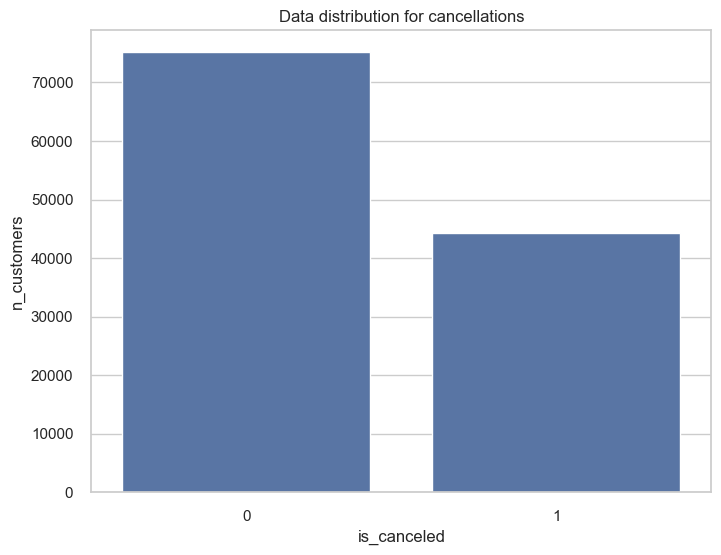

In [9]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(
    data = (tbl_data
            .groupby(['is_canceled'])
            .size()
            .reset_index(name = 'n_customers')),
    x = 'is_canceled',
    y = 'n_customers'
)
plt.title("Data distribution for cancellations")
plt.show()

In [10]:
def fun_downsample(tbl):
    '''
    Función para hacer downsampling
    tbl: Son los datos originales en forma de dataframe.
    '''
    # Filtramos la clase mayoritaria y sacamos de manera aleatoria N observaciones.
    # N es igual al número de observaciones en la clase minoritaria.
    # Observa que fijo una semilla en el random_state para garantizar reproducibilidad.
    tbl_reservations_not_cancelled = (
        tbl
            .query('is_canceled == 0')
            .sample(
                n = tbl.groupby(['is_canceled']).size()[1],
                random_state=42)
    )
    # Filtramos la clase minoritaria.
    tbl_reservations_cancelled = tbl.query('is_canceled == 1')

    return pd.concat([
        tbl_reservations_not_cancelled,
        tbl_reservations_cancelled
    ])

tbl_downsampled_data = fun_downsample(tbl_data)

* Observa como igualamos las proporciones de las clases a 50:50
* Desde luego que perdemos mucha información, sin embargo, el costo no es superior al beneficio.
* El beneficio será que nuestro algorítmo será capaz de atrapar más verdaderos positivos que sin debalance.
* Puede haber casos en los que esto no funcioné y tengamos que aplicar otra distribución, pero por ahora lo dejamos así.

In [11]:
(tbl_downsampled_data
     .groupby(['is_canceled'])
     .size()
     .reset_index(name = 'n_reservaciones')
     .assign(pct = lambda df_: df_.n_reservaciones / df_.n_reservaciones.sum() * 100)
     .round(1)
)

,is_canceled,n_reservaciones,pct
0,0,44224,50.0
1,1,44224,50.0


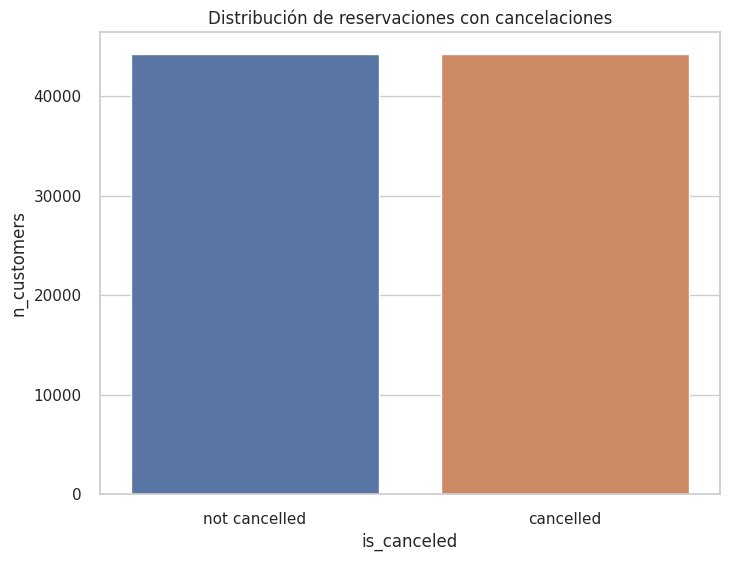

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(
    data = (tbl_downsampled_data
            .groupby(['is_canceled'])
            .size()
            .reset_index(name = 'n_customers')
            .assign(is_canceled = lambda df_: df_.is_canceled.replace({0: 'not cancelled', 1: 'cancelled'}))),
    x = 'is_canceled',
    y = 'n_customers'
)
plt.title("Distribución de reservaciones con cancelaciones")
plt.show()

## Construimos los conjuntos de entrenamiento

In [12]:
from sklearn.model_selection import train_test_split


y = tbl_downsampled_data.is_canceled
X = tbl_downsampled_data.drop(columns = 'is_canceled')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=X_test.shape[0],
    random_state=SEED,
    stratify=y_train
)

In [13]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: (53068, 31)
y_train shape: (53068,)


In [14]:
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_val shape: (17690, 31)
y_val shape: (17690,)


In [15]:
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_test shape: (17690, 31)
y_test shape: (17690,)


In [16]:
print(f"Distrubucón de y_train para la variable dependiente:\n{y_train.value_counts(normalize=True)}\n")
print(f"Distrubucón de y_val para la variable dependiente:\n{y_val.value_counts(normalize=True)}\n")
print(f"Distrubucón de y_test para la variable dependiente:\n{y_test.value_counts(normalize=True)}\n")

Distrubucón de y_train para la variable dependiente:
is_canceled
0    0.5
1    0.5
Name: proportion, dtype: float64

Distrubucón de y_val para la variable dependiente:
is_canceled
1    0.5
0    0.5
Name: proportion, dtype: float64

Distrubucón de y_test para la variable dependiente:
is_canceled
0    0.5
1    0.5
Name: proportion, dtype: float64



In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

variable_selection_numeric = ['arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights']
variable_selection_categoric = ['customer_type','deposit_type']               # <--- Selecciona las variable categóricas

def prep_for_ml(tbl_train, tbl_val, tbl_test, variable_selection_numeric, variable_selection_categoric, scaled:bool = False):
    '''Clean X_train and X_test
        1) Select continuous and categorical variables.
        2) Convert categorical variables to one hot encoding
        3) Concatenate clean dataframes
    '''
    # Continuous variables
    tbl_num_train = tbl_train.loc[:, variable_selection_numeric]
    tbl_num_val = tbl_val.loc[:, variable_selection_numeric]
    tbl_num_test = tbl_test.loc[:, variable_selection_numeric]

    if scaled is True:
        train_scaled = StandardScaler().fit_transform(tbl_num_train)
        val_scaled = StandardScaler().fit_transform(tbl_num_val)
        test_scaled = StandardScaler().fit_transform(tbl_num_test)

        tbl_num_train = pd.DataFrame(train_scaled, columns=tbl_num_train.columns)
        val_scaled = pd.DataFrame(val_scaled, columns=tbl_num_val.columns)
        test_scaled = pd.DataFrame(test_scaled, columns=tbl_num_test.columns)


    # Categorical variables
    tbl_cat_train = tbl_train.loc[:, variable_selection_categoric]
    tbl_cat_val = tbl_val.loc[:, variable_selection_categoric]
    tbl_cat_test = tbl_test.loc[:, variable_selection_categoric]

    ohe = OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output=False)
    ohe.fit(tbl_cat_train)
    col_names = ohe.get_feature_names_out()

    tbl_ohe_cat_train = pd.DataFrame(
        ohe.transform( tbl_cat_train )
    )

    tbl_ohe_cat_val = pd.DataFrame(
        ohe.transform( tbl_cat_val )
    )

    tbl_ohe_cat_test = pd.DataFrame(
        ohe.transform( tbl_cat_test )
    )
    # Add new column names
    tbl_ohe_cat_train.columns = col_names
    tbl_ohe_cat_val.columns = col_names
    tbl_ohe_cat_test.columns = col_names

    # Join transformed continuous + categorical variables
    tbl_train_clean = pd.concat([tbl_num_train.reset_index(drop = True), tbl_ohe_cat_train], axis = 1)
    tbl_val_clean = pd.concat([tbl_num_val.reset_index(drop = True), tbl_ohe_cat_val], axis = 1)
    tbl_test_clean = pd.concat([tbl_num_test.reset_index(drop = True), tbl_ohe_cat_test], axis = 1)

    return (tbl_train_clean, tbl_val_clean, tbl_test_clean)



In [18]:
compare_results = pd.DataFrame(columns=['model','auc','score','precision','recall'])
compare_results

,model,auc,score,precision,recall


In [19]:
def get_model_insight(
    model_name,
    clf,
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results,
    scaled: bool = False,
):
    if not variable_selection_numeric:
        variable_selection_numeric = ['arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights']

    if not variable_selection_categoric:
        variable_selection_categoric = ['customer_type','deposit_type']

    X_train_clean, X_val_clean, X_test_clean = prep_for_ml(
        X_train,
        X_val,
        X_test,
        variable_selection_numeric,
        variable_selection_categoric,
        scaled
    )

    clf_model = clf.fit( X_train_clean, y_train )
    predictions = clf_model.predict(X_test_clean)

    res = {
        'model': model_name,
        'auc': roc_auc_score(y_test, predictions),
        'score': f1_score(y_test, predictions) ,
        'precision': precision_score(y_test, predictions),
        'recall': recall_score(y_test, predictions)
        }

    results = pd.DataFrame(res, index=[compare_results.shape[0]])

    compare_results = pd.concat([compare_results,results])

    display(compare_results)

    cm = ConfusionMatrix(
        clf,
        classes=['not cancelled','cancelled']
    )
    cm.fit(X_train_clean, y_train)
    cm.score(X_val_clean, y_val)
    cm.show()

    return clf_model, compare_results

#### Modelo Base (fail fast)

/var/folders/y8/k7c5p2ls0f3_m21w3lj_lftr0000gn/T/ipykernel_96831/1567867154.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare_results = pd.concat([compare_results,results])


,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


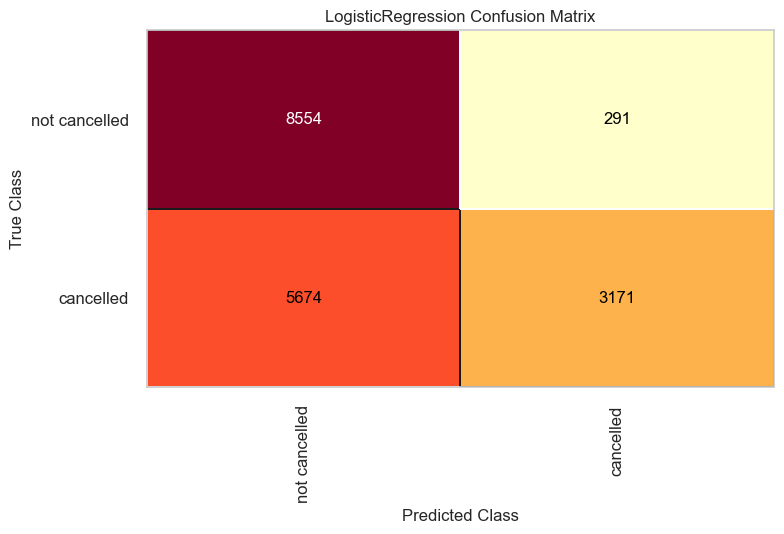

In [20]:
variable_selection_numeric = ['arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights']
variable_selection_categoric = ['customer_type','deposit_type']

base_model, compare_results = get_model_insight(
    'Regresion Logistica c/ 3 num, 2 cat',
    LogisticRegression(random_state=SEED),
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results,
    )

**Analisis y comentarios**: El score es muy bajo (52%, como lanzar una moneda al aire) dado que el modelo es muy malo prediciendo reservaciones canceladas, de todas las que predijo, solo el 36% realmente fueron canceladas. Asi que intentaremos añadiendo mas caracteristicas al modelo

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917
1,"Regresion Logistica c/ 4 num, 3 cat",0.680780,0.613246,0.777797,0.506162


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


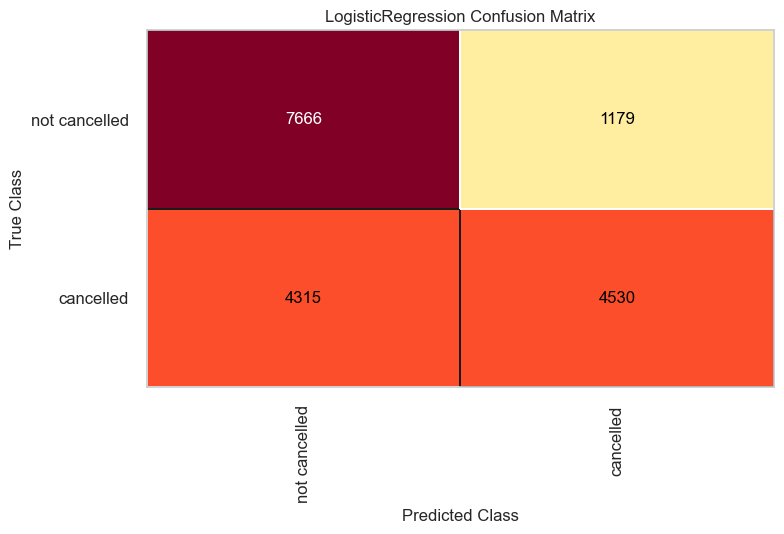

In [21]:
'''
Seleccion de variables y justificacion:

Numericas
    - 'arrival_date_week_number': tiene alta correlacion con el mes y nos ayuda
      a describir el punto del año en el que ocurre la reserva sin necesidad de
      transformar el mes de forma ordinal
    - 'stays_in_weekend_nights' 'stays_in_week_nights' no ayuda a desscribir el
      punto de la semana en la que ocurre la reserva

Categoricas
- 'hotel': mi hipotesis es que un resort puede sufrir mas cancelaciones que un
  city hotel
- 'customer_type':
- 'deposit_type':
'''

variable_selection_numeric = [
    'arrival_date_week_number',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'lead_time',
]
variable_selection_categoric = ['hotel','customer_type','deposit_type']

base_model_w_4num_4cat, compare_results = get_model_insight(
    'Regresion Logistica c/ 4 num, 3 cat',
    LogisticRegression(random_state=SEED),
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results
    )

**Analisis y comentarios**: A pesar de que el score subio vemos que la precision callo y el recal mejoró un poco. Tan malo es que no predigamos bien los cancelados como los no cancelados, pues ambos tiene un impacto economico en la empresa que dara los incentivos. Veamos si podemos mejorar el desempeño usando caracteristicas que estan altamente correlacionadas con la variable dependiente 'is_cancelled'

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917
1,"Regresion Logistica c/ 4 num, 3 cat",0.680780,0.613246,0.777797,0.506162
2,"Regresion Logistica c/ 5 num, 3 cat",0.736066,0.717047,0.772727,0.668852


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


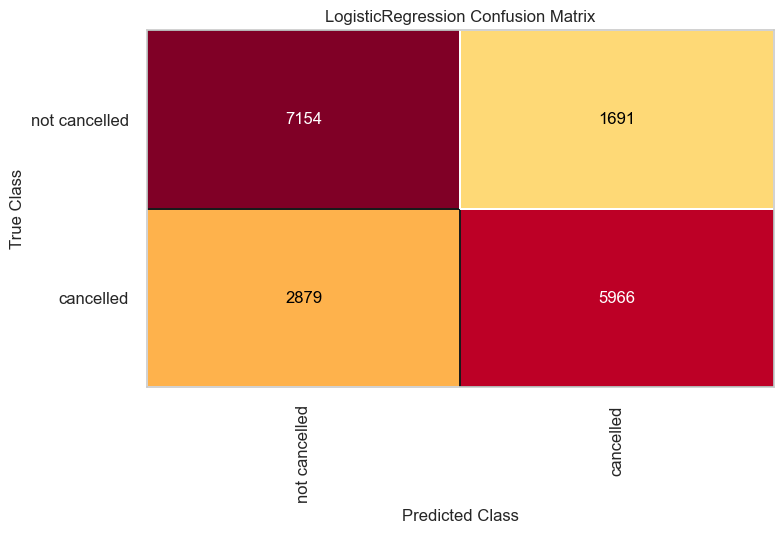

In [22]:
'''
Seleccion de variables y justificacion:

Numericas
    - 'arrival_date_week_number': tiene alta correlacion con el mes y nos ayuda
      a describir el punto del año en el que ocurre la reserva sin necesidad de
      transformar el mes de forma ordinal
    - 'stays_in_weekend_nights' 'stays_in_week_nights' no ayuda a desscribir el
      punto de la semana en la que ocurre la reserva
    - 'lead_time' 'total_of_special_requests': en el EDA resulto altamente
      correlacionado con is_canceled

Categoricas
- 'hotel': mi hipotesis es que un resort puede sufrir mas cancelaciones que un city hotel
- 'market_segment' y 'deposit_type': en el EDA resulto altamente
      correlacionado con is_canceled
'''
variable_selection_numeric = [
    'arrival_date_week_number',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'lead_time',
    'total_of_special_requests',
]
variable_selection_categoric = ['hotel', 'market_segment','deposit_type']

base_model_w_5num_3cat, compare_results = get_model_insight(
    'Regresion Logistica c/ 5 num, 3 cat',
    LogisticRegression(random_state=SEED),
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results
    )

**Analisis y comentarios**: El recall mejoró considerablemente en comparacion de el modelo base, sin embargo, el score sigue estando algo bajo. Veamos si mejora añadiendo un par de variables mas.

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917
1,"Regresion Logistica c/ 4 num, 3 cat",0.680780,0.613246,0.777797,0.506162
2,"Regresion Logistica c/ 5 num, 3 cat",0.736066,0.717047,0.772727,0.668852
3,"Regresion Logistica c/ 8 num, 5 cat",0.750989,0.733240,0.789515,0.684454


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


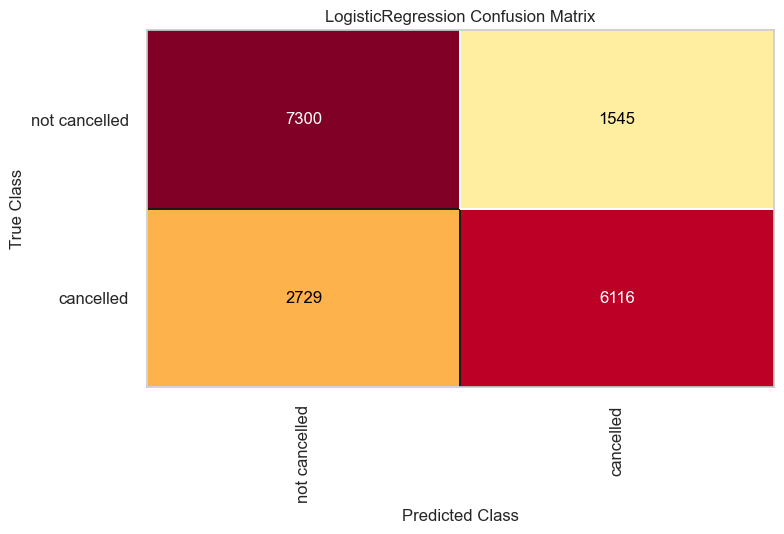

In [23]:
variable_selection_numeric = [
    'arrival_date_week_number',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'lead_time',
    'total_of_special_requests',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
]
variable_selection_categoric = [
    'hotel',
    'market_segment',
    'deposit_type',
    'customer_type',
    'meal'
]

base_model_w_8num_5cat, compare_results = get_model_insight(
    'Regresion Logistica c/ 8 num, 5 cat',
    LogisticRegression(random_state=SEED),
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results
    )

**Analisis y comentarios**: el score subio un 2% con las nuevas variables, el modelo lanza un warning de convergencia, entonces vamos a intentar scalar los datos (info obtenida de [stackoverflow](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter))

,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917
1,"Regresion Logistica c/ 4 num, 3 cat",0.680780,0.613246,0.777797,0.506162
2,"Regresion Logistica c/ 5 num, 3 cat",0.736066,0.717047,0.772727,0.668852
3,"Regresion Logistica c/ 8 num, 5 cat",0.750989,0.733240,0.789515,0.684454
4,"Regresion Logistica c/ 8 num, 5 cat, datos esc...",0.540362,0.682816,0.521263,0.989486


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


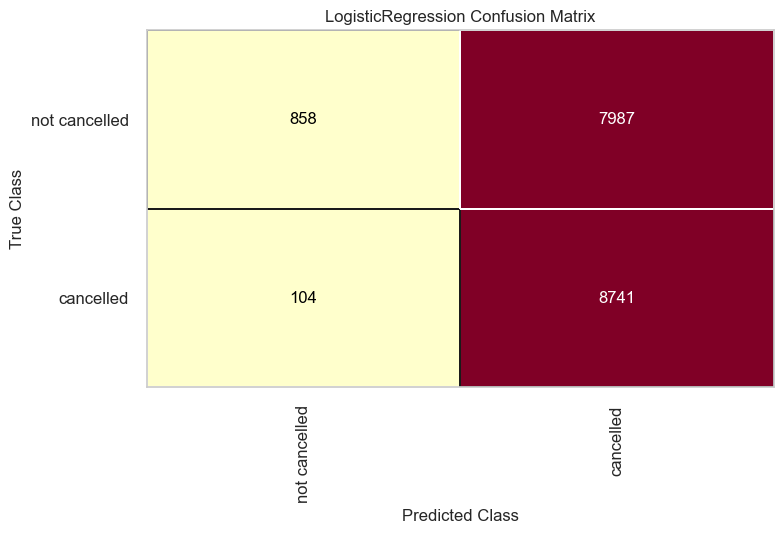

In [24]:
variable_selection_numeric = [
    'arrival_date_week_number',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'lead_time',
    'total_of_special_requests',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
]
variable_selection_categoric = [
    'hotel',
    'market_segment',
    'deposit_type',
    'customer_type',
    'meal'
]

base_model_w_8num_5cat_scaled, compare_results = get_model_insight(
    'Regresion Logistica c/ 8 num, 5 cat, datos escalados',
    LogisticRegression(random_state=SEED),
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results,
    scaled = True,
)

**Analisis y comentarios**: el recall subio considerablemente pero ahora la precisión esta por los suelos, intentemos ajustar los hiperparametros para ver si con el mejor modelo optenemos un mejor resultado

In [25]:
# tomada de el archivo compartido en clase profundiza
def fun_plot_grid_search_results(df):
    '''Regresa un DataFrame con los resultados de la exploración de hiperparámetros.

    Esta función muestra una tabla estilizada con los resultados de la exploración de
    hiper parámetros utilizando validación cruzada.

    En la tabla aparecen del lado izquierdo la combinación de hiperparámetros, el error
    de entrenamiento y el error de validación cruzada y el ranking del mejor modelo
    a partir del error de validación.

    El mapa de color va de azul (modelos con menor error) a rojo (modelos con mayor error).
    Se calcula para el error de entrenamiento y validación de manera separada.

    Los resultados están ordenados de mejor a peor modelo, en función del error de validación.

    Parameters
    ----------
    dict: Diccionario con los resultados de la búsqueda de hiperparámetros GridSearchCV.cv_results_

    Returns
    -------
    pandas.io.formats.style.Styler
        Regresa una tabla estilizada con los resultados de la búsqueda de hiperparámetros.
    '''
    # Elegir paleta divergente de colores
    cm = sns.diverging_palette(5, 250, as_cmap=True)

    return (
        pd.concat([
            # Limpiar la columna de parámetros
            df['params'].apply(pd.Series),
            # Extraer solamente el error de prueba
            df[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
            axis = 1
        )
        # Ordenar los modelos de mejor a peor
        .sort_values(by = 'rank_test_score')
        # Pintar el fondo de la celda a partir del error de validación
        .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
    )

def fun_resumen_grid_search(grid_search):
    '''Imprime un resumen del grid search.

    Imprime el número de modelos que se entrenaron y
    devuelve los hiperparámetros del mejor modelo.

    Parameters
    ----------
    grid_search (GridSearchCV): Fitted GridSearch con los resultados.
    '''
    best_params = grid_search.best_params_
    print("\nSe evaluaron {} modelos utilizando el grid search.".format(pd.DataFrame(grid_search.cv_results_).shape[0]))
    print("\nLos hiperparámetros del mejor modelo son: " + str(best_params) + "\n")

In [26]:
# Usamos las variables que nos dieron mejor resultado en el ejercicio anterior
variable_selection_numeric = [
    'arrival_date_week_number',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'lead_time',
    'total_of_special_requests',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
]
variable_selection_categoric = [
    'hotel',
    'market_segment',
    'deposit_type',
    'customer_type',
    'meal'
]

X_train_lg, X_val_lg, X_test_lg = prep_for_ml(
        X_train,
        X_val,
        X_test,
        variable_selection_numeric,
        variable_selection_categoric,
    )

# Especificamos el modelo de Regresion Logistica
clf_lg = LogisticRegression(random_state=SEED)

# Especificamos el diccionario de parámetros y valores a explorar
params = {
    'max_iter': [*range(100,500,50)],
    'penalty': ['l2'],
    'C': [0.001, 0.01, 1, 10, 100]
}

grid_search = RandomizedSearchCV(
    clf_lg,
    scoring = 'roc_auc',
    param_distributions = params,
    random_state = SEED,
    cv=10,
    return_train_score=True,
)

grid_search.fit(X_train_lg, y_train)

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': [0.001, 0.01, 1, 10, 100],
                                        'max_iter': [100, 150, 200, 250, 300,
                                                     350, 400, 450],
                                        'penalty': ['l2']},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [27]:
# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,penalty,max_iter,C,mean_train_score,mean_test_score,rank_test_score
8,l2,450,100.000000,0.830200,0.829861,1
6,l2,350,100.000000,0.829747,0.829329,2
7,l2,250,10.000000,0.829160,0.828930,3
0,l2,250,1.000000,0.829081,0.828853,4
3,l2,200,10.000000,0.828855,0.828660,5
2,l2,450,0.010000,0.826968,0.826681,6
5,l2,300,0.010000,0.826842,0.826531,7
1,l2,100,1.000000,0.825479,0.825663,8
9,l2,400,0.001000,0.810392,0.810160,9
4,l2,300,0.001000,0.810390,0.810156,10


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917
1,"Regresion Logistica c/ 4 num, 3 cat",0.680780,0.613246,0.777797,0.506162
2,"Regresion Logistica c/ 5 num, 3 cat",0.736066,0.717047,0.772727,0.668852
3,"Regresion Logistica c/ 8 num, 5 cat",0.750989,0.733240,0.789515,0.684454
4,"Regresion Logistica c/ 8 num, 5 cat, datos esc...",0.540362,0.682816,0.521263,0.989486
5,"Regresion Logistica c/ 8 num, 5 cat, best params",0.754607,0.735515,0.797569,0.682419


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


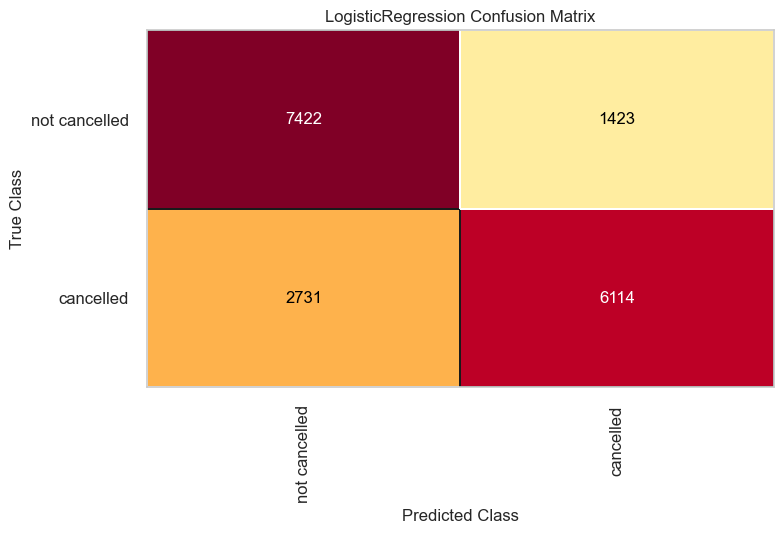

<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [28]:
best_model_LR = grid_search.best_estimator_
clf_model = best_model_LR.fit( X_train_lg, y_train)
predictions = clf_model.predict(X_test_lg)
res = {
    'model': 'Regresion Logistica c/ 8 num, 5 cat, best params',
    'auc': roc_auc_score(y_test, predictions),
    'score': f1_score(y_test, predictions) ,
    'precision': precision_score(y_test, predictions),
    'recall': recall_score(y_test, predictions)
    }

results = pd.DataFrame(res, index=[compare_results.shape[0]])

compare_results = pd.concat([compare_results,results])

display(compare_results)

cm = ConfusionMatrix(
    best_model_LR,
    classes=['not cancelled','cancelled']
)
cm.fit(X_train_lg, y_train)
cm.score(X_val_lg, y_val)
cm.show()

**Analisis y observaciones**: Hasta ahora ha sido el mejor modelo de regresion logistica que hemos podido obtener, sin embargo, el solo poder predecir el 68% de las reservaciones canceladas sigue sin ser un buen numero. Intentemos un modelo de arboles

### Prueba con otro Random Forest y ajuste de hiperparámetros 

,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917
1,"Regresion Logistica c/ 4 num, 3 cat",0.680780,0.613246,0.777797,0.506162
2,"Regresion Logistica c/ 5 num, 3 cat",0.736066,0.717047,0.772727,0.668852
3,"Regresion Logistica c/ 8 num, 5 cat",0.750989,0.733240,0.789515,0.684454
4,"Regresion Logistica c/ 8 num, 5 cat, datos esc...",0.540362,0.682816,0.521263,0.989486
5,"Regresion Logistica c/ 8 num, 5 cat, best params",0.754607,0.735515,0.797569,0.682419
6,"Random Forest c/ 8 num, 5 cat",0.807010,0.803001,0.820035,0.786659


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


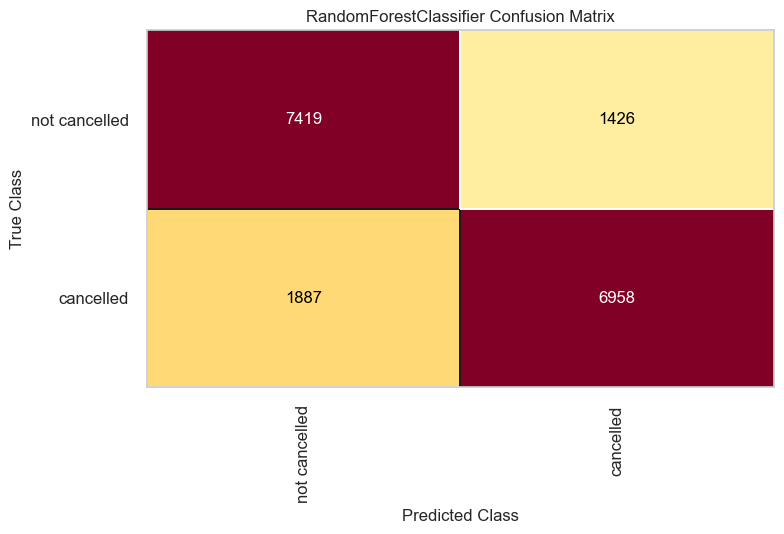

In [29]:
variable_selection_numeric = [
    'arrival_date_week_number',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'lead_time',
    'total_of_special_requests',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
]
variable_selection_categoric = [
    'hotel',
    'market_segment',
    'deposit_type',
    'customer_type',
    'meal'
]

X_train_clean, X_val_clean, X_test_clean = prep_for_ml(
        X_train,
        X_val,
        X_test,
        variable_selection_numeric,
        variable_selection_categoric,
)

rfc_w_8num_5cat, compare_results = get_model_insight(
    'Random Forest c/ 8 num, 5 cat',
    RandomForestClassifier(random_state=SEED),
    variable_selection_numeric,
    variable_selection_categoric,
    compare_results,
)

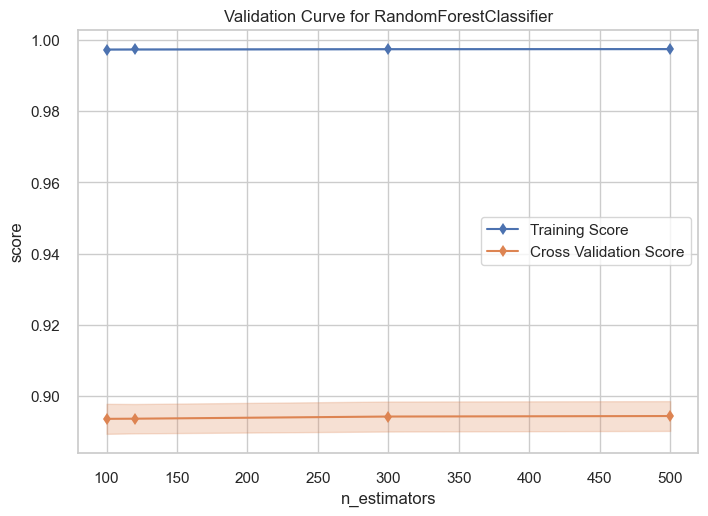

In [30]:
from yellowbrick.model_selection import ValidationCurve

clf_rfc = RandomForestClassifier(random_state=SEED)
# Especificamos la curva de validación
viz = ValidationCurve(
    clf_rfc, 							# Especificar el modelo (debe ser un estiamdor)
    param_name="n_estimators",				# Especificar un solo hiperparámetro a evaluar
    param_range=[100, 120, 300, 500],
    cv=10, 								# Indicar el valor k, para construir la validación cruzada
    scoring="roc_auc",					# Indicar la métrica de evaluación para el modelo.
)
# Ajustamos el modelo y la visualización
viz.fit(X_train_clean, y_train)
# Imprimimos en la pantalla la visualización.
viz.show();

**Analisis y comentarios**: Vemos que para el conjunto de validacion no varia mucho el resultado dependiendo del numero de estimadores, asi que un valor entre 100 y 120 deberia ser suficiente

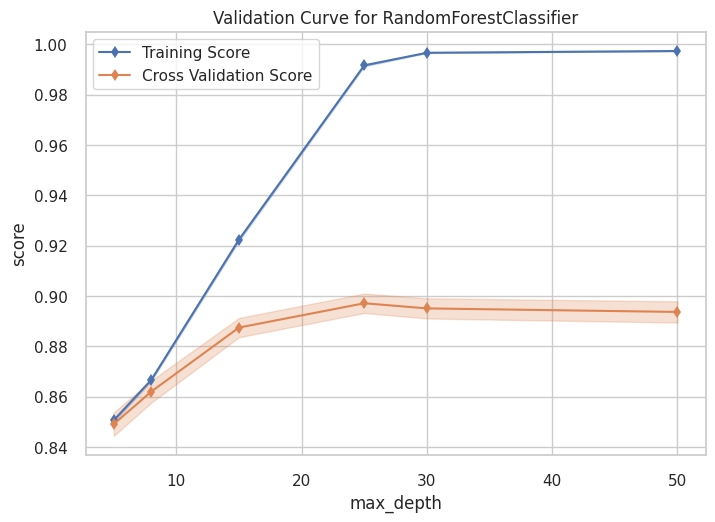

In [ ]:
# Especificamos la curva de validación
viz = ValidationCurve(
    clf_rfc, 							# Especificar el modelo (debe ser un estimador)
    param_name="max_depth",				# Especificar un solo hiperparámetro a evaluar
    param_range=[5, 8, 15, 25, 30, 50],
    cv=10, 								# Indicar el valor k, para construir la validación cruzada
    scoring="roc_auc",					# Indicar la métrica de evaluación para el modelo.
)
# Ajustamos el modelo y la visualización
viz.fit(X_train_clean, y_train)
# Imprimimos en la pantalla la visualización.
viz.show()

**Analisis y comentarios**: Vemos que conforme aumentamos el hiperparametro ```max_depth``` crece el sobreajuste del modelo, por ende tomaremos el rango de 5 a 25 que es donde la curva de validación toma su máximo valor

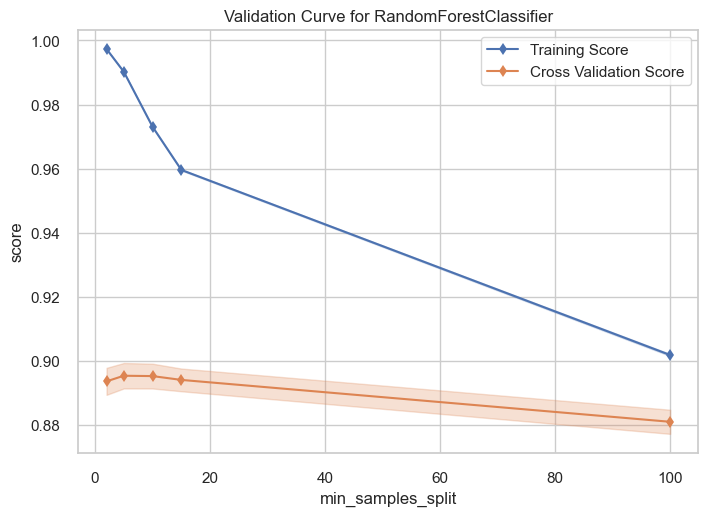

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='min_samples_split', ylabel='score'>

In [31]:
# Especificamos la curva de validación
viz = ValidationCurve(
    clf_rfc, 							# Especificar el modelo (debe ser un estimador)
    param_name="min_samples_split",				# Especificar un solo hiperparámetro a evaluar
    param_range=[1, 2, 5, 10, 15, 100],
    cv=10, 								# Indicar el valor k, para construir la validación cruzada
    scoring="roc_auc",					# Indicar la métrica de evaluación para el modelo.
)
# Ajustamos el modelo y la visualización
viz.fit(X_train_clean, y_train)
# Imprimimos en la pantalla la visualización.
viz.show()

**Analisis y comentarios**: Vemos que conforme aumentamos el hiperparametro `min_sample_split` el score decrece en general. Sin embargo, hay un rango entre 2 y 5 en el que se mantiene estable.


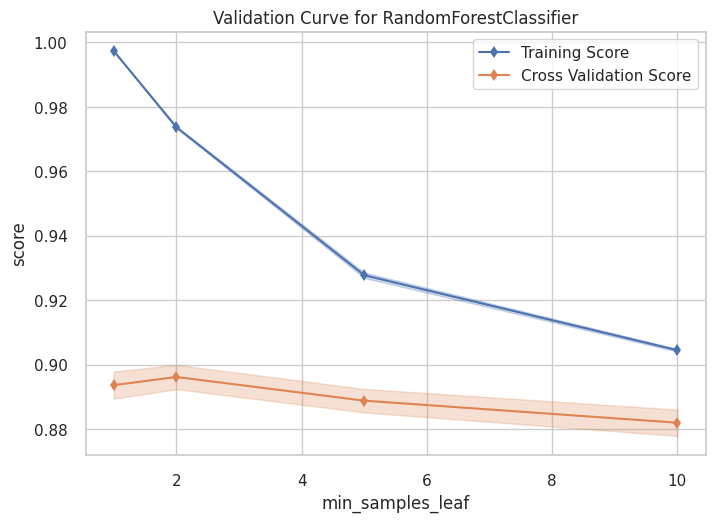

In [ ]:
# Especificamos la curva de validación
viz = ValidationCurve(
    clf_rfc, 							# Especificar el modelo (debe ser un estimador)
    param_name="min_samples_leaf",				# Especificar un solo hiperparámetro a evaluar
    param_range=[1, 2, 5, 10],
    cv=10, 								# Indicar el valor k, para construir la validación cruzada
    scoring="roc_auc",					# Indicar la métrica de evaluación para el modelo.
)
# Ajustamos el modelo y la visualización
viz.fit(X_train_clean, y_train)
# Imprimimos en la pantalla la visualización.
viz.show();

**Analisis y comentarios**: El score en la curva de validación y training decrese excepto en ```min_samples_leaf = 2``` asi que tomaremos ese unico valor para el ajuste de hiperparametros  

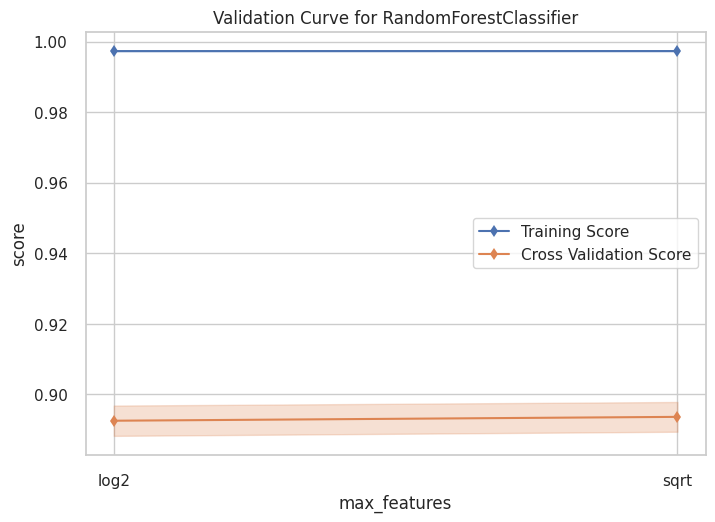

In [ ]:
# Especificamos la curva de validación
viz = ValidationCurve(
    clf_rfc, 							# Especificar el modelo (debe ser un estimador)
    param_name="max_features",				# Especificar un solo hiperparámetro a evaluar
    param_range=['log2', 'sqrt', 'None'],
    cv=10, 								# Indicar el valor k, para construir la validación cruzada
    scoring="roc_auc",					# Indicar la métrica de evaluación para el modelo.
)
# Ajustamos el modelo y la visualización
viz.fit(X_train_clean, y_train)
# Imprimimos en la pantalla la visualización.
viz.show();

**Analisis y comentarios**: El algorithmo parece no tener mucha influencia en el performance del modelo

In [32]:

# Especificamos el diccionario de parámetros a partir del analisis anterior
params = {
    'n_estimators': [*range(100,120,5)],
    'max_depth': [5, 8, 15, 25],
    'min_samples_split':[*range(2,5,1)],
    'min_samples_leaf' : [2],
    'max_features' : ['log2', 'sqrt'],
}

grid_search = RandomizedSearchCV(
    clf_rfc,
    scoring = 'roc_auc',
    param_distributions = params,
    random_state = SEED,
    cv=10,
    return_train_score=True,
)

grid_search.fit(X_train_clean, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 8, 15, 25],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 105, 110, 115]},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [33]:
# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(grid_search.cv_results_)
tabla_resultados = fun_plot_grid_search_results(df_best_params)
tabla_resultados

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,mean_train_score,mean_test_score,rank_test_score
3,110,4,2,sqrt,25,0.965658,0.896328,1
5,115,3,2,log2,25,0.962138,0.895837,2
1,105,3,2,log2,25,0.962157,0.895816,3
2,105,2,2,log2,25,0.962157,0.895816,3
0,100,4,2,log2,25,0.962074,0.895810,5
6,105,4,2,sqrt,15,0.912580,0.884976,6
7,110,3,2,sqrt,8,0.866084,0.861768,7
4,105,4,2,log2,8,0.863796,0.859597,8
8,100,2,2,log2,5,0.846081,0.844519,9
9,110,4,2,log2,5,0.845600,0.844089,10


,model,auc,score,precision,recall
0,"Regresion Logistica c/ 3 num, 2 cat",0.665969,0.520723,0.921355,0.362917
1,"Regresion Logistica c/ 4 num, 3 cat",0.680780,0.613246,0.777797,0.506162
2,"Regresion Logistica c/ 5 num, 3 cat",0.736066,0.717047,0.772727,0.668852
3,"Regresion Logistica c/ 8 num, 5 cat",0.750989,0.733240,0.789515,0.684454
4,"Regresion Logistica c/ 8 num, 5 cat, datos esc...",0.540362,0.682816,0.521263,0.989486
5,"Regresion Logistica c/ 8 num, 5 cat, best params",0.754607,0.735515,0.797569,0.682419
6,"Random Forest c/ 8 num, 5 cat",0.807010,0.803001,0.820035,0.786659
7,"Random Forest c/ 8 num, 5 cat, best params {'n...",0.807066,0.797556,0.838907,0.760090


/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


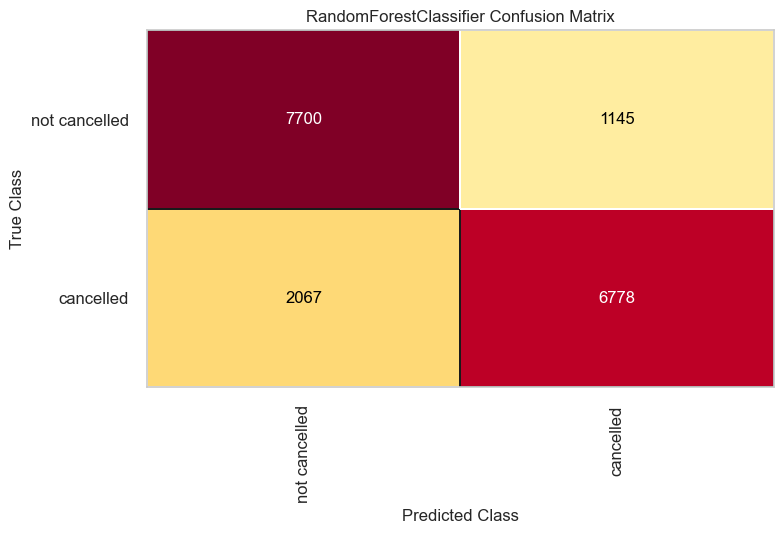

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [34]:
best_model_RFC = grid_search.best_estimator_
clf_model = best_model_RFC.fit( X_train_clean, y_train )
predictions = clf_model.predict(X_test_clean)
res = {
    'model': f"Random Forest c/ 8 num, 5 cat, best params {grid_search.best_params_}",
    'auc': roc_auc_score(y_test, predictions),
    'score': f1_score(y_test, predictions) ,
    'precision': precision_score(y_test, predictions),
    'recall': recall_score(y_test, predictions)
    }

results = pd.DataFrame(res, index=[compare_results.shape[0]])

compare_results = pd.concat([compare_results,results])

display(compare_results)

cm = ConfusionMatrix(
    best_model_RFC,
    classes=['not cancelled','cancelled']
)
cm.fit(X_train_clean, y_train)
cm.score(X_val_clean, y_val)
cm.show()

**Analisis y comentarios**: Parece que hemos llegado a un error irreducible de 80% pudieramos intentar con otro modelo o bien seleccionando un punto de corte distinto.

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


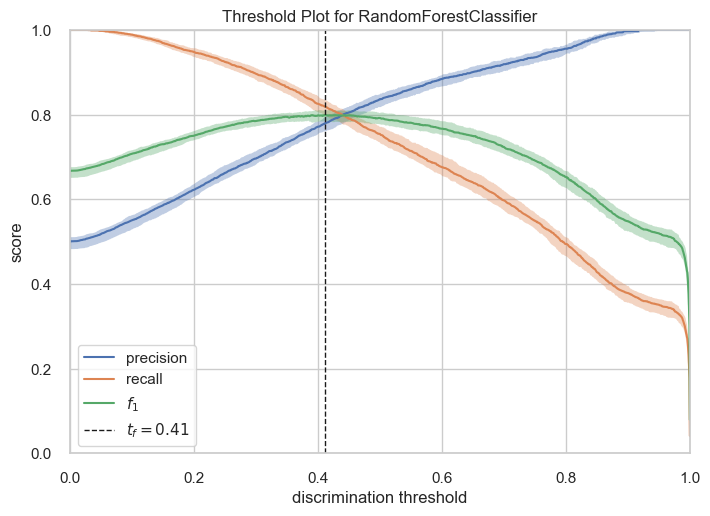

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [35]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
# Especificamos la gráfica
visualizer = DiscriminationThreshold(
	best_model_RFC,							# Pasar el estimador del mejor modelo que
    									# se obtiene de la validación cruzada.
	exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_val_clean, y_val)
# Dibjuamos la visualización.
visualizer.show()

In [36]:
# Tomado de la clase de profundiza
# Clasificar con un punto de corte más alto que 0.5
def fun_predict_with_threshold(model, X_val, threshold = 0.5):
    '''Predice la clase del cliente utilizando un threshold

    Permite predecir la clase de un cliente utilizando otros
    puntos de corte (threshold) que sean diferentes a 0.5.

    Parameters
    ----------
    model: Fitted estimator
    threshold (float): Punto de corte entre 0 y 1.

    Returns
    -------
    ndarray:
        Regresa un numpy array con el valor de la clase 0 ó 1
    '''
    return np.where( model.predict_proba(X_val)[:,1] < threshold, 0, 1 )

#### Predicciones

In [37]:
# Utilizar el mejor modelo para predecir la clase
y_pred = best_model_RFC.predict(X_val_clean)
# Mostrar las clases de los primeros 20
y_pred[:20]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [38]:
# Utilizar el mejor modelo para predecir la probabilidad.
y_pred_proba = best_model_RFC.predict_proba(X_val_clean)[:,1]
# Mostrar las probabilidades de los primeros 20
y_pred_proba[:20]

array([0.8709016 , 0.44218554, 0.99751469, 1.        , 0.39404326,
       0.99489736, 0.71284311, 0.99366009, 0.99952033, 0.22235953,
       0.02631947, 0.05511353, 0.99628879, 0.40653621, 0.40988444,
       0.76186778, 0.2265914 , 0.41350823, 0.10259404, 0.09615083])

In [39]:
# Calcular clases con un punto de corte en 0.38
y_pred_038 = fun_predict_with_threshold(best_model_RFC, X_val_clean, threshold = 0.40)
# Mostrar primeros 20
y_pred_038[:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0])

#### Curva ROC del mejor modelo

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


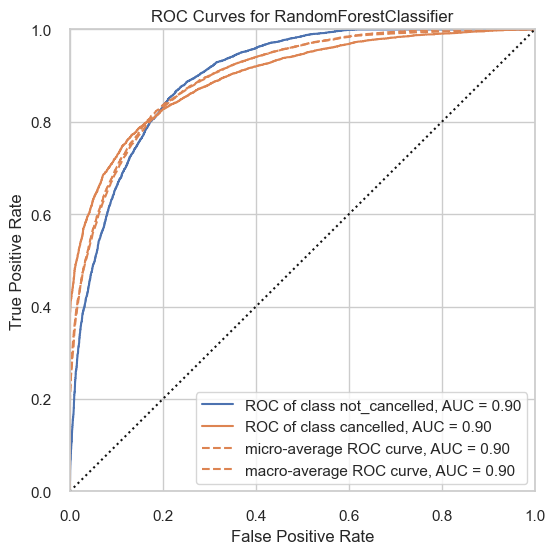

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [40]:
from yellowbrick.classifier import ROCAUC
# Especificamos la curva ROC AUC
fig, ax = plt.subplots(figsize = (6,6))
roc_curves_visualizer = ROCAUC(
    best_model_RFC,
    classes=['not_cancelled', 'cancelled']
)

# Ajustamos la visualización a los datos de entrenamiento
roc_curves_visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
roc_curves_visualizer.score(X_val_clean, y_val)
# Dibjuamos la visualización.
roc_curves_visualizer.show()

#### Precision y el recall.

/Users/xochitl.cedillo/conda_envs/mlops-bootcamp-team10/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


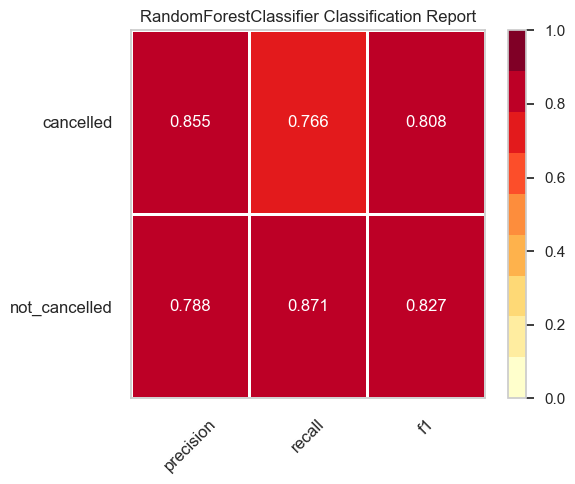

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [41]:
from yellowbrick.classifier import ClassificationReport
fig, ax = plt.subplots(figsize = (6,5))
visualizer = ClassificationReport(
    best_model_RFC,
    classes=['not_cancelled', 'cancelled']
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_train_clean, y_train)
# Evaluamos los errores en la predicción utilizando los datos de validación.
visualizer.score(X_val_clean, y_val)
# Dibjuamos la visualización.
visualizer.show()

#### **Conclusiones**

El modelo parece tener un desempeño aceptable en general, sin embargo, el recall esta por debajo del 80%, es decir, solo podemos predecir bien el 76% de los casos cancelados. Cambiar el punto de corte pudiera ayudar a mejorar este resultado, sin embargo, esto haría que tuvieramos un incremento en falsos positivos, que se traduce en incentivos que el cliente ofrecería sin ser necesarios.


Lo ideal seria ultilizar un algoritmo distinto, como XGBoost para comparar su performance.

### Genera un CSV con tus predicciones, utilizando el mejor modelo entrenado con los datos de prueba.

* Reporte en CSV, con la predicción de la clase y la predicción de la probabilidad de cancelación.

In [42]:
X_val

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
13582,Resort Hotel,195,2017,August,34,20,4,9,2,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,240.0,NaN,0,Transient,180.00,0,0,Canceled,2017-04-24
38158,Resort Hotel,204,2017,July,26,1,4,6,2,1.0,0,HB,ROU,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,240.0,NaN,0,Transient,185.50,0,2,Check-Out,2017-07-11
53007,City Hotel,188,2016,June,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119.0,NaN,39,Transient,130.00,0,0,Canceled,2016-01-18
80472,City Hotel,34,2015,December,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,Non Refund,19.0,NaN,0,Transient,90.00,0,0,Canceled,2015-11-17
40129,City Hotel,65,2015,July,28,10,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,68.85,0,1,Canceled,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111777,City Hotel,76,2017,May,19,10,1,4,2,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,B,0,No Deposit,7.0,NaN,0,Transient,112.32,0,0,Check-Out,2017-05-15
43709,City Hotel,83,2015,September,39,23,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,NaN,0,Transient-Party,62.00,0,0,Check-Out,2015-09-25
66755,City Hotel,104,2017,April,17,24,1,4,3,0.0,0,BB,NLD,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,9.0,NaN,0,Transient,162.35,0,1,Canceled,2017-01-20
85311,City Hotel,41,2016,March,11,10,0,3,2,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,83.90,0,1,Check-Out,2016-03-13


In [43]:
is_cancelled_model_pred = pd.DataFrame(y_pred, columns=['is_cancelled_model_pred'], index=y_val.index)
is_cancelled_model_pred

,is_cancelled_model_pred
13582,1
38158,0
53007,1
80472,1
40129,0
...,...
111777,1
43709,0
66755,0
85311,0


In [46]:
is_cancelled_model_pred_pct = pd.DataFrame(y_pred_proba, columns=['is_cancelled_model_pred_pct'],index=y_val.index)
is_cancelled_model_pred_pct

,is_cancelled_model_pred_pct
13582,0.870902
38158,0.442186
53007,0.997515
80472,1.000000
40129,0.394043
...,...
111777,0.768758
43709,0.143385
66755,0.345106
85311,0.339377


In [44]:
is_cancelled_model_pred_threshold_038 = pd.DataFrame(y_pred_038, columns=['is_cancelled_model_pred_threshold_038'],index=y_val.index)
is_cancelled_model_pred_threshold_038

,is_cancelled_model_pred_threshold_038
13582,1
38158,1
53007,1
80472,1
40129,0
...,...
111777,1
43709,0
66755,0
85311,0


In [47]:
results = pd.concat([X_val, y_val, is_cancelled_model_pred, is_cancelled_model_pred_pct, is_cancelled_model_pred_threshold_038], axis= 1)
# results = pd.concat([X_val, y_val], axis= 1)
results

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_canceled,is_cancelled_model_pred,is_cancelled_model_pred_pct,is_cancelled_model_pred_threshold_038
13582,Resort Hotel,195,2017,August,34,20,4,9,2,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,240.0,NaN,0,Transient,180.00,0,0,Canceled,2017-04-24,1,1,0.870902,1
38158,Resort Hotel,204,2017,July,26,1,4,6,2,1.0,0,HB,ROU,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,240.0,NaN,0,Transient,185.50,0,2,Check-Out,2017-07-11,0,0,0.442186,1
53007,City Hotel,188,2016,June,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119.0,NaN,39,Transient,130.00,0,0,Canceled,2016-01-18,1,1,0.997515,1
80472,City Hotel,34,2015,December,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,Non Refund,19.0,NaN,0,Transient,90.00,0,0,Canceled,2015-11-17,1,1,1.000000,1
40129,City Hotel,65,2015,July,28,10,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,68.85,0,1,Canceled,2015-07-01,1,0,0.394043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111777,City Hotel,76,2017,May,19,10,1,4,2,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,B,0,No Deposit,7.0,NaN,0,Transient,112.32,0,0,Check-Out,2017-05-15,0,1,0.768758,1
43709,City Hotel,83,2015,September,39,23,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,NaN,0,Transient-Party,62.00,0,0,Check-Out,2015-09-25,0,0,0.143385,0
66755,City Hotel,104,2017,April,17,24,1,4,3,0.0,0,BB,NLD,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,9.0,NaN,0,Transient,162.35,0,1,Canceled,2017-01-20,1,0,0.345106,0
85311,City Hotel,41,2016,March,11,10,0,3,2,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,83.90,0,1,Check-Out,2016-03-13,0,0,0.339377,0


In [48]:
results.to_csv('../data/processed/results_notebook3.02-xc.csv')